# Part2:c
In this part the first hidden layer is introduced. This means we have two weight matrices and two bias vectors that need to be caluclated. This makes the back propagation slightly more difficult, where the chain rule is applied

#### Import Libraries
First things first, get organised with what libraries will be used later on.

In [2]:
import traceback
import sys, os, time
import pdb
import random
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 


Will be using a neural network class, so first it would be easiest to define some fucntions that will be used in the network.

## Softmax, Crossentropy and Relu.
Softmax and Crossentropy will be to calculate the probability of the labels and the loss. Relu will be used to calculate the nonlinearity

Since batches will not be used in the main function, vectors will be passed into the softmax function.

In [4]:
def softmax(z):
    
    return np.exp(z)/np.exp(z).sum()

In [5]:
def Xent(pred,true):
    
    return np.dot(true.T, np.log(pred)).item()

In [6]:
def relu(z,deriv = False):
    
    #function that takes the argument of wheter derivative or not.
    if deriv == False:
        return np.maximum(z,0)
        
    # For the derivative: f'(x_i) = 1 if  x_i>0, 0 otherwise    
    elif deriv == True:
        positive =np.maximum(z,0)
        positive_index = positive>0
        positive[positive_index] = 1
        return positive

# Create a Neural Network Class
This is where all the heavy liffting will be done. The arguments passed through will be the data, the layers, and the number of iterations.

In [22]:
class network(object):
    

    def __init__(self,x_train, y_train, x_test,y_test, eta, layers, units ):
        
        
        #initialize the varibles of object be
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.input_num = len(y_test)
        self.eta = eta
        self.layers = layers
        self_num_layers = layers
        self.units = units
        self.train_acc =[]
        self.train_loss = []
        self.test_acc = []
        self.test_loss =[]
        self.length = np.linspace(1,len(y_train),11)
        # Since there is now two weights and biases, it is easier to work with lists in for loops
        
        # Make space for weights and biases
        
        self.W = []
        self.b = []
        
        # W_1 and b_1
        self.W.append(np.random.normal(loc=0.0, scale=0.1, size=[self.units, 784]))
        self.b.append(np.random.normal(loc=0.0, scale=0.1, size=[self.units, 1]))
        
        # W_2 and b_2
        self.W.append(np.random.normal(loc=0.0, scale=0.1, size=[10, self.units]))
        self.b.append(np.random.normal(loc=0.0, scale=0.1, size=[10, 1]))
        
        # Store values for the outputs of each layer
        self.outputs = (self.layers+1)*[None]
        
        # Store values for the gradients
        self.dLdW = self.layers*[None]
        self.dLdb = self.layers*[None]
    
    # non-linear activation funcion and softmax. If the last layer, appply softmax
    def act(self, z, layer):
        if layer == self.layers:
                
            return softmax(z)
            
        else:
            return relu(z, deriv=False)
                
    def feed_forward(self,x,y):
        
        x = np.reshape(x,[784,1])
        true = np.reshape(y,[10,1])
        
        self.outputs[0] = x
        for i in range(1, self.layers+1):
            
            # apply linear layer
            #pdb.set_trace()
            self.outputs[i] = np.dot(self.W[i-1],self.outputs[i-1]) + self.b[i-1]

            # apply relu/ softmax
            self.outputs[i] = self.act(self.outputs[i],i)
        #pdb.set_trace()    
        
        #store the pred labels as the last layer
        pred = self.outputs[self.layers]
        L = Xent(pred,true)
        
        return[pred,true,x,L]

    def back_prop(self,x,pred,true):
        # initial gradient is given in the slides and worked out in part2 a.
        dLdy = pred - true
        
        for i in range (1,-1,-1):
            self.dLdW[i] = np.dot(dLdy,self.outputs[i].T)
            self.dLdb[i] = dLdy
            
            # update the gradient for next iteration
            # since only use dLdy twice we can apply the relu
            # derivative as if it was there twice
            
            dLdy = np.dot(self.W[i].T,dLdy)
            #pdb.set_trace()
            dLdy = dLdy * relu(self.outputs[i],deriv = True)
    
    def SGD(self):
        # Want to run through all images and update weights
        # To do stochastic gradient descent, need to shuffle
            
        #dont forget to update seed in main
        #random.seed(a=2)
            
        # to make sure the shuffle is the same for both x and y data
        r = random.random()
        random.shuffle(self.x_train,lambda:r)
        random.shuffle(self.y_train,lambda:r)
        freq = len(y_train)/10
            
        for i in range(len(y_train)):
            #feed forward
            [pred,true,x,L] =self.feed_forward(self.x_train[i,],self.y_train[i])
                
            #back_prop
            self.back_prop(x,pred,true)
                
            # update gradients
            #print(i)
            #pdb.set_trace()
            # apply gradient descent.
            for j in range(0,2,1):
                
                self.W[j] = self.W[j]- self.eta*self.dLdW[j]
                self.b[j] = self.b[j] -self.eta*self.dLdb[j]
            
            # Accuracy
            if  i%freq == 0 or i == len(y_train)-1:
                errors_train = 0
                errors_test = 0
                #pdb.set_trace()
                # calculate the accuracy at different iterations
                for j in range(len(y_train)):
                    
                    [pred_train,true_train,x_train,L_train] =self.feed_forward(self.x_train[j,],self.y_train[j])
                    if np.argmax(pred_train) != np.argmax(true_train):
                        errors_train += 1
                for j in range(self.input_num):       
                    [pred_test,true_test,x_test,L_test] =self.feed_forward(self.x_test[j,],self.y_test[j])
                    if np.argmax(pred_test) != np.argmax(true_test):
                        errors_test += 1   
                
                accuracy_train = 1-(errors_train/len(y_train))
                self.train_acc.append(accuracy_train)
                self.train_loss.append(-L_train)
                
                accuracy_test = 1- errors_test/self.input_num
                self.test_acc.append(accuracy_test)
                self.test_loss.append(-L_test)

                print("iteration:{0:>6}, \t\t Train Accuracy:{1:6.1%}\n".format(1+i, 1-errors_train/len(y_train)))
                print("\t\t \t\t Test Accuracy:{1:6.1%}\n".format(1+i, 1- errors_test/self.input_num))
        #print(len(self.train_acc))
        #print(len(self.test_acc))                
        return(self.train_acc,self.test_acc,self.length,self.train_loss,self.test_loss)        

### Import the data

In [8]:
# Import data
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('mnist_data/', one_hot=True)
x_train = data.train.images
y_train = data.train.labels
x_test = data.test.images
y_test = data.test.labels
#print(x_train.shape[1])

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [9]:
print('The size of the data that we will be working with:')
print('train set: {} '.format(len(y_train)))
print('valid set: {} '.format(len(data.validation.labels)))
print('test set:  {} '.format(len(y_test)))


The size of the data that we will be working with:
train set: 55000 
valid set: 5000 
test set:  10000 


### Accuracy
Same idea as part b, except need to feed forward the hidden layer this time.

In [14]:
def Final_accuracy(x, labels, W,b,Train = True):
    iters = len(labels)
    errors = 0
    
    for i in range(iters):
        xi = np.reshape(x[i,],[784,1])
        true_label = np.reshape(labels[i], [10,1])
        linear_1 = np.dot(W[0], xi) + b[0]
        activation = relu(linear_1,deriv = False)
        
        linear_2 = np.dot(W[1],activation)+b[1]
        y = np.argmax(softmax(linear_2))
        if y!=np.argmax(true_label):
            errors+=1
    if Train == True:       
        print("Train Accuracy:{1:6.1%}\n".format(1+i, 1- errors/iters))
    else:print("Test Accuracy:{1:6.1%}\n".format(1+i, 1- errors/iters))    

### Create NN object
Create a a NN and apply SGD over all images.


In [23]:
start = time.time()
linear_network = network(x_train,y_train,x_test,y_test,0.0075,2,128)

cycle = 1
for k in range(cycle):
    [train_acc10,test_acc10,length10,train_loss10,test_loss10] =linear_network.SGD()

Weights = linear_network.W
biases = linear_network.b

# Save weights
with open("models_part2/Weights2c.pkl", 'wb') as f:
        pickle.dump(Weights, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("models_part2/Biases2c.pkl", 'wb') as f:
        pickle.dump(biases, f, protocol=pickle.HIGHEST_PROTOCOL)

time_taken = time.time()- start
print('Time taken to train was: {}s'.format(time_taken))

iteration:     1, 		 Train Accuracy: 10.6%

		 		 Test Accuracy: 11.0%

iteration:  5501, 		 Train Accuracy: 87.6%

		 		 Test Accuracy: 88.5%

iteration: 11001, 		 Train Accuracy: 90.1%

		 		 Test Accuracy: 90.7%

iteration: 16501, 		 Train Accuracy: 91.6%

		 		 Test Accuracy: 91.9%

iteration: 22001, 		 Train Accuracy: 92.8%

		 		 Test Accuracy: 92.9%

iteration: 27501, 		 Train Accuracy: 92.3%

		 		 Test Accuracy: 92.6%

iteration: 33001, 		 Train Accuracy: 93.6%

		 		 Test Accuracy: 93.7%

iteration: 38501, 		 Train Accuracy: 94.5%

		 		 Test Accuracy: 94.7%

iteration: 44001, 		 Train Accuracy: 94.2%

		 		 Test Accuracy: 94.1%

iteration: 49501, 		 Train Accuracy: 94.1%

		 		 Test Accuracy: 94.1%

iteration: 55000, 		 Train Accuracy: 95.0%

		 		 Test Accuracy: 94.9%

Time taken to train was: 90.37963342666626s


In [24]:
Final_accuracy(x_train,y_train, Weights,biases, Train = True)
Final_accuracy(x_test,y_test, Weights,biases, Train = False)


Train Accuracy: 95.0%

Test Accuracy: 94.9%



### Plot Accuracy and Loss

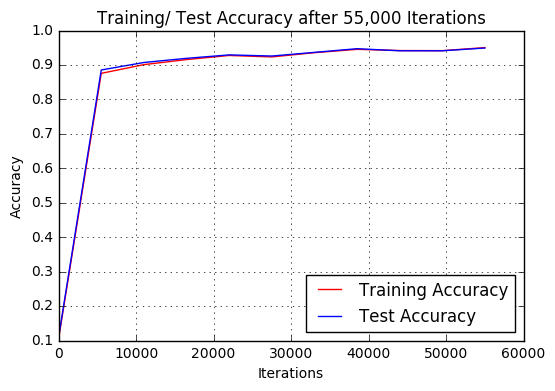

In [25]:
plt.title('Training/ Test Accuracy after 55,000 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.grid(True)


plt.plot(length10,train_acc10,color="red", label="Training Accuracy")
plt.plot(length10,test_acc10,color="blue", label="Test Accuracy")

plt.legend( loc='lower right')
plt.savefig("Accuracy_part2c.png", bbox_inches='tight')
plt.show()

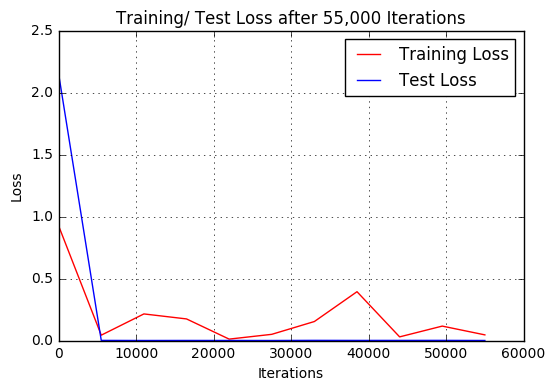

In [42]:
plt.title('Training/ Test Loss after 55,000 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.grid(True)
plt.plot(length10,train_loss10,color="red", label="Training Loss")
plt.plot(length10,test_loss10,color="blue", label="Test Loss")

plt.legend( loc='upper right')
plt.savefig("Loss_part2c.png", bbox_inches='tight')
plt.show()


### Confussion matrix 

In [32]:
def compute_confusion_mat(x_data, y_data, W, b):
    y_pred = []
    y_true = []
    
    for i in range(len(y_data)):
        x = np.reshape(x_data[i,],[784,1])
        true = np.reshape(y_data[i],[10,1])
        
        #pdb.set_trace()
        linear_trans = np.dot(W[0],x)+ b[0]
        non_lin = relu(linear_trans, deriv = False)
        linear_trans_2 = np.dot(W[1],non_lin) +b[1]        
        pred = softmax(linear_trans_2)
        y_pred.append(np.argmax(pred))
        y_true.append(np.argmax(true))
        
    #db.set_trace()    
    return confusion_matrix(np.array(y_true), np.array(y_pred))


[[ 961    0    0    2    0    7    1    2    5    2]
 [   0 1092    2    4    0    0    3    1   33    0]
 [   6    2  957   17    3    1    5    7   33    1]
 [   0    0    2  976    0    9    0    6   16    1]
 [   0    0    4    2  891    2    8    1   10   64]
 [   2    2    0   17    1  848    5    0   13    4]
 [   5    3    4    1    7   11  919    1    7    0]
 [   0    7   12   13    3    2    0  944    4   43]
 [   2    0    1   14    3    5    4    3  940    2]
 [   1    2    0    7    7    3    2    5   19  963]]


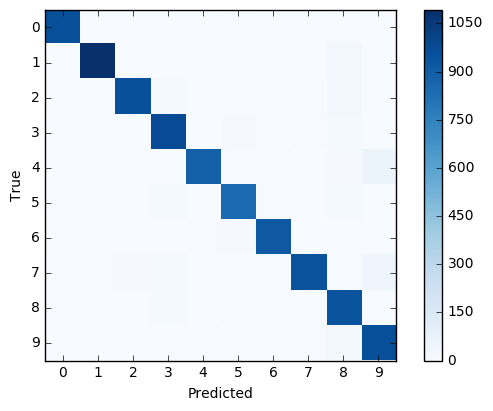

In [43]:
# Confusion matrix
confusion_mat = compute_confusion_mat(x_test, y_test, linear_network.W, linear_network.b)
print(confusion_mat)
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.tight_layout()
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("CM_part2_c.png", bbox_inches='tight')
plt.show()

## Load model.
Run this to to load the weights and biaes that will produce the final accuracy. This is to check, if you like, if the results are the same as they are in the report.

In [1]:
import traceback
import sys, os, time
import pdb
import random
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 


In [2]:
#Weights = np.load("models_part2/Weights_2b.dat")
#biases = np.load("models_part2/biases_2b.dat")
with open("models_part2/Weights2c.pkl", 'rb') as f:
    weights = pickle.load(f)
with open("models_part2/Biases2c.pkl", 'rb') as f:
    biases = pickle.load(f)

In [3]:
# Import data
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('mnist_data/', one_hot=True)
x_train = data.train.images
y_train = data.train.labels
x_test = data.test.images
y_test = data.test.labels
#print(x_train.shape[1])

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [4]:
def softmax(z):
    
    return np.exp(z)/np.exp(z).sum()

In [5]:
def relu(z,deriv = False):
    
    if deriv == False:
        return np.maximum(z,0)
        
    # For the derivative: f'(x_i) = 1 if  x_i>0, 0 otherwise    
    elif deriv == True:
        positive =np.maximum(z,0)
        positive_index = positive>0
        positive[positive_index] = 1
        return positive

In [6]:
def Final_accuracy(x, labels, W,b,Train = True):
    iters = len(labels)
    errors = 0
    
    for i in range(iters):
        xi = np.reshape(x[i,],[784,1])
        true_label = np.reshape(labels[i], [10,1])
        linear_1 = np.dot(W[0], xi) + b[0]
        activation = relu(linear_1,deriv = False)
        
        linear_2 = np.dot(W[1],activation)+b[1]
        y = np.argmax(softmax(linear_2))
        if y!=np.argmax(true_label):
            errors+=1
    if Train == True:       
        print("Train Accuracy:{1:6.1%}\n".format(1+i, 1- errors/iters))
    else:print("Test Accuracy:{1:6.1%}\n".format(1+i, 1- errors/iters))    

In [7]:
Final_accuracy(x_train,y_train, weights,biases, Train = True)
Final_accuracy(x_test,y_test, weights,biases, Train = False)

Train Accuracy: 95.1%

Test Accuracy: 94.9%



In [11]:
def compute_confusion_mat(x_data, y_data, W, b):
    y_pred = []
    y_true = []
    
    for i in range(len(y_data)):
        x = np.reshape(x_data[i,],[784,1])
        true = np.reshape(y_data[i],[10,1])
        
        #pdb.set_trace()
        linear_trans = np.dot(W[0],x)+ b[0]
        non_lin = relu(linear_trans, deriv = False)
        linear_trans_2 = np.dot(W[1],non_lin) +b[1]        
        pred = softmax(linear_trans_2)
        y_pred.append(np.argmax(pred))
        y_true.append(np.argmax(true))
        
    #db.set_trace()    
    return confusion_matrix(np.array(y_true), np.array(y_pred))


In [12]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, range(10))
    plt.yticks(tick_marks, range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    #plt.tight_layout()

    width, height = cm.shape
    
    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.savefig("CM_part2_c.png", bbox_inches='tight')

    plt.show()

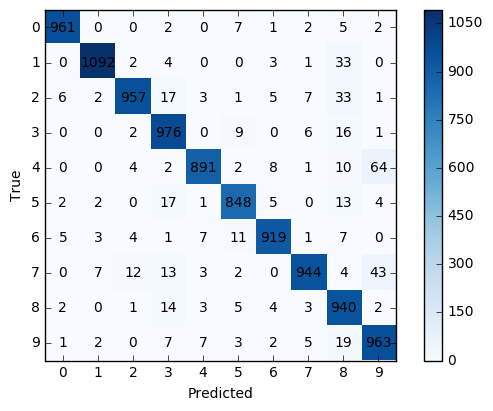

In [13]:
conf_mat = compute_confusion_mat(x_test, y_test, weights, biases)
digits = np.array([np.linspace(0,9,10)])
plot_confusion_matrix(conf_mat, digits)